In [ ]:
# -*- coding: utf-8 -*-
"""
Image Captioning with ResNet50 and BiLSTM on Flickr8k.
This script includes full evaluation metrics and beam search decoding.
"""

# --- Step 0: Install necessary libraries and restart runtime ---
# Run this cell once, then restart the runtime from the menu (Runtime -> Restart runtime)
# After restarting, run all cells again from the beginning.
!pip install pycocotools -q  # UNCOMMENT THIS
!pip install pycocoevalcap -q # UNCOMMENT THIS
import os
print("Restarting runtime...")
os.kill(os.getpid(), 9) # UNCOMMENT THIS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 7.7 MB/s eta 0:00:00


In [1]:
# --- Step 1: Import Libraries ---
import os
import string
import numpy as np
import pandas as pd
from PIL import Image
import pickle
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Embedding, Dropout, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# NLTK for tokenization (used by evaluation library)
import nltk
try:
    nltk.data.find('tokenizers/punkt')
# Change this line: Catch LookupError instead of nltk.downloader.DownloadError
except LookupError:
    print("Downloading NLTK 'punkt' model...")
    nltk.download('punkt', quiet=True) # Use quiet=True to suppress download messages

# Evaluation libraries
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

# --- Step 2: Mount Google Drive and Configure Paths ---
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/model_captioning'
IMAGES_PATH = os.path.join(BASE_PATH, 'Flicker8k_Dataset')
CAPTIONS_FILE = os.path.join(BASE_PATH, 'Flickr8k_text/Flickr8k.token.txt')
TRAIN_FILE = os.path.join(BASE_PATH, 'Flickr8k_text/Flickr_8k.trainImages.txt')
DEV_FILE = os.path.join(BASE_PATH, 'Flickr8k_text/Flickr_8k.devImages.txt')
TEST_FILE = os.path.join(BASE_PATH, 'Flickr8k_text/Flickr_8k.testImages.txt')
FEATURES_PKL = os.path.join(BASE_PATH, 'features_resnet50.pkl')
MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'model_resnet_bilstm_best.keras')

# --- Step 3: Hyperparameters ---
EMBEDDING_DIM = 256
LSTM_UNITS = 256
DROPOUT_RATE = 0.5
BATCH_SIZE = 64
EPOCHS = 20
BEAM_WIDTH = 5


Mounted at /content/drive


In [2]:
# --- Step 4: Data Loading and Preprocessing Functions ---
def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

def load_set_ids(filename):
    doc = load_doc(filename)
    return set(line.split('.')[0] for line in doc.split('\n') if len(line) >= 1)

def load_captions(filename, dataset_ids):
    doc = load_doc(filename)
    captions = defaultdict(list)
    for line in tqdm(doc.split('\n'), desc="Loading captions"):
        tokens = line.split()
        if len(tokens) < 2:
            continue
        image_id, image_desc = tokens[0].split('.')[0], tokens[1:]
        if image_id in dataset_ids:
            captions[image_id].append(' '.join(image_desc))
    return captions

def clean_captions(captions_dict):
    table = str.maketrans('', '', string.punctuation)
    cleaned_captions = {}
    for key, desc_list in tqdm(captions_dict.items(), desc="Cleaning captions"):
        cleaned_list = []
        for desc in desc_list:
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word) > 1 and word.isalpha()]
            cleaned_list.append(' '.join(desc))
        cleaned_captions[key] = cleaned_list
    return cleaned_captions

def add_start_end_tokens(captions_dict):
    processed_captions = {}
    for key, desc_list in captions_dict.items():
        processed_captions[key] = ['startseq ' + desc + ' endseq' for desc in desc_list]
    return processed_captions


In [3]:
# --- Step 5: Execute Data Loading and Preprocessing ---
print("--- Loading and Preprocessing Data ---")
train_ids = load_set_ids(TRAIN_FILE)
dev_ids = load_set_ids(DEV_FILE)
test_ids = load_set_ids(TEST_FILE)
print(f"Train samples: {len(train_ids)}, Dev samples: {len(dev_ids)}, Test samples: {len(test_ids)}")

# Load captions for all sets
all_ids = train_ids.union(dev_ids).union(test_ids)
all_captions_raw = load_captions(CAPTIONS_FILE, all_ids)

# Clean captions - this is for evaluation references
all_captions_cleaned = clean_captions(all_captions_raw)
test_captions_cleaned = {k: v for k, v in all_captions_cleaned.items() if k in test_ids}

# Prepare captions for training (add start/end tokens)
train_captions_for_model = {k: v for k, v in all_captions_cleaned.items() if k in train_ids}
dev_captions_for_model = {k: v for k, v in all_captions_cleaned.items() if k in dev_ids}
train_captions = add_start_end_tokens(train_captions_for_model)
dev_captions = add_start_end_tokens(dev_captions_for_model)

--- Loading and Preprocessing Data ---
Train samples: 6000, Dev samples: 1000, Test samples: 1000


Loading captions:   0%|          | 0/40461 [00:00<?, ?it/s]

Cleaning captions:   0%|          | 0/8000 [00:00<?, ?it/s]

In [4]:
# --- Step 6: Image Feature Extraction ---
def extract_features(directory, image_ids):
    model = ResNet50(weights='imagenet')
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    features = {}
    for name in tqdm(image_ids, desc="Extracting ResNet50 features"):
        filename = os.path.join(directory, name + '.jpg')
        try:
            image = load_img(filename, target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, *image.shape))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            features[name] = feature
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    return features

if not os.path.exists(FEATURES_PKL):
    print("Extracting features for all images...")
    all_features = extract_features(IMAGES_PATH, all_ids)
    print(f"Extracted features for {len(all_features)} images.")
    with open(FEATURES_PKL, 'wb') as f:
        pickle.dump(all_features, f)
else:
    print(f"Loading pre-extracted features from {FEATURES_PKL}...")
    with open(FEATURES_PKL, 'rb') as f:
        all_features = pickle.load(f)

train_features = {k: all_features[k] for k in train_ids if k in all_features}
dev_features = {k: all_features[k] for k in dev_ids if k in all_features}
test_features = {k: all_features[k] for k in test_ids if k in all_features}
print(f"Features loaded: Train={len(train_features)}, Dev={len(dev_features)}, Test={len(test_features)}")

feature_size = list(train_features.values())[0].shape[-1] if train_features else 2048

Loading pre-extracted features from /content/drive/MyDrive/model_captioning/features_resnet50.pkl...
Features loaded: Train=6000, Dev=1000, Test=1000


In [5]:
# --- Step 7: Tokenization and Data Preparation ---
def create_tokenizer(captions_dict):
    all_desc_list = [cap for key in captions_dict for cap in captions_dict[key]]
    tokenizer = Tokenizer(oov_token="<unk>")
    tokenizer.fit_on_texts(all_desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(d.split()) for key in train_captions for d in train_captions[key])
print(f"Vocabulary Size: {vocab_size}, Max Caption Length: {max_length}")
word_to_index = tokenizer.word_index
index_to_word = {idx: word for word, idx in word_to_index.items()}


def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, feature_size, batch_size):
    # Khởi tạo danh sách tạm thời để lưu trữ dữ liệu trong một batch
    X1_batch, X2_batch, y_batch = [], [], []
    n = 0 # Bộ đếm số lượng cặp input/output trong batch hiện tại

    # Lấy tất cả các cặp (image_id, caption) có sẵn
    all_data_items = []
    for key in descriptions.keys():
        if key in photos:
            for desc in descriptions[key]:
                all_data_items.append((key, desc))

    while True:
        # Xáo trộn dữ liệu ở mỗi epoch để tránh overfitting theo thứ tự
        np.random.shuffle(all_data_items)

        for key, desc in all_data_items:
            photo_feature = photos[key][0] # photo_feature sẽ có shape (feature_size,)

            # Chuyển đổi caption thành chuỗi số nguyên
            seq = tokenizer.texts_to_sequences([desc])[0]

            # Tạo các cặp input-output từ chuỗi
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]

                # Padding chuỗi đầu vào và đảm bảo kiểu dữ liệu là int32
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post', dtype='int32')[0]

                # Chuyển đổi từ đầu ra thành one-hot encoding và đảm bảo kiểu float32
                out_seq = to_categorical([out_seq], num_classes=vocab_size, dtype='float32')[0]

                # Thêm vào batch hiện tại
                X1_batch.append(photo_feature)
                X2_batch.append(in_seq)
                y_batch.append(out_seq)
                n += 1

                # Nếu đủ batch_size, yield và reset batch
                if n >= batch_size:
                    yield (
                        (np.array(X1_batch, dtype=np.float32), np.array(X2_batch, dtype=np.int32)),
                        np.array(y_batch, dtype=np.float32)
                    )
                    X1_batch, X2_batch, y_batch = [], [], []
                    n = 0

        # Sau khi duyệt hết tất cả các item, nếu còn dữ liệu sót lại trong batch, yield nốt
        if n > 0:
            yield (
                (np.array(X1_batch, dtype=np.float32), np.array(X2_batch, dtype=np.int32)),
                np.array(y_batch, dtype=np.float32)
            )
            X1_batch, X2_batch, y_batch = [], [], []
            n = 0


def create_tf_dataset(descriptions, photos, tokenizer, max_length, vocab_size, feature_size, batch_size):
    # Tính toán tổng số lượng sequence (cặp input-output) cho việc tính steps_per_epoch
    # Mỗi caption có độ dài L sẽ tạo ra L-1 cặp (input, output)
    num_sequences = 0
    for key in descriptions.keys():
        if key in photos:
            for desc in descriptions[key]:
                # texts_to_sequences trả về list of lists, lấy [0] để có list of integers
                seq_len = len(tokenizer.texts_to_sequences([desc])[0])
                if seq_len > 1: # Cần ít nhất 2 từ để tạo 1 cặp (input, output)
                    num_sequences += (seq_len - 1)

    steps_per_epoch = num_sequences // batch_size
    if num_sequences % batch_size != 0:
        steps_per_epoch += 1 # Đảm bảo xử lý hết tất cả dữ liệu

    # Output signature cần khớp với kiểu dữ liệu và shape của từng phần tử mà generator yield
    output_signature = (
        (tf.TensorSpec(shape=(None, feature_size), dtype=tf.float32),  # (batch_size, feature_size)
         tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),     # (batch_size, max_length)
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)      # (batch_size, vocab_size)
    )

    # Truyền batch_size vào data_generator
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(descriptions, photos, tokenizer, max_length, vocab_size, feature_size, batch_size),
        output_signature=output_signature
    ).prefetch(tf.data.AUTOTUNE) # Sử dụng prefetch để cải thiện hiệu suất

    return dataset, steps_per_epoch

Vocabulary Size: 7580, Max Caption Length: 34


In [6]:
# --- Step 8: Model Definition ---
def define_model_bilstm(vocab_size, max_length, feature_size, embedding_dim, lstm_units):
    inputs1 = Input(shape=(feature_size,))
    fe1 = Dropout(DROPOUT_RATE)(inputs1)
    fe2 = Dense(2 * lstm_units, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(DROPOUT_RATE)(se1)
    se3 = Bidirectional(LSTM(lstm_units))(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(lstm_units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [7]:
# --- Step 9: Training the Model ---
print("\n--- Model Training ---")
model = define_model_bilstm(vocab_size, max_length, feature_size, EMBEDDING_DIM, LSTM_UNITS)

train_dataset, steps_train = create_tf_dataset(train_captions, train_features, tokenizer, max_length, vocab_size, feature_size, BATCH_SIZE)
dev_dataset, steps_dev = create_tf_dataset(dev_captions, dev_features, tokenizer, max_length, vocab_size, feature_size, BATCH_SIZE)

print(f"Steps per epoch (train): {steps_train}, Steps per epoch (dev): {steps_dev}")

checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1, restore_best_weights=True)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_train,
    validation_data=dev_dataset,
    validation_steps=steps_dev,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

print(f"Training completed. Best model saved to {MODEL_SAVE_PATH}")



--- Model Training ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  1,940,480 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │  1,050,624 │ dropout_1[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ dense[0][0],      │
│                     │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7580)      │  1,948,060 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,119,580 (23.34 MB)

 Trainable params: 6,119,580 (23.34 MB)

 Non-trainable params: 0 (0.00 B)

Steps per epoch (train): 4788, Steps per epoch (dev): 807
Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: to_categorical() got an unexpected keyword argument 'dtype'
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-5-d8566fd11268>", line 46, in data_generator
    out_seq = to_categorical([out_seq], num_classes=vocab_size, dtype='float32')[0]
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

TypeError: to_categorical() got an unexpected keyword argument 'dtype'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_5888]

In [ ]:
# --- Step 10: Evaluation Functions ---
def generate_caption_greedy(model, tokenizer, photo_feature, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_feature, sequence], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = index_to_word.get(yhat_idx)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return ' '.join(in_text.split()[1:])

def generate_caption_beam_search(model, tokenizer, photo_feature, max_length, beam_width):
    start_token_idx = word_to_index['startseq']
    sequences = [([start_token_idx], 0.0)]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == word_to_index.get('endseq', -1):
                all_candidates.append((seq, score))
                continue
            input_seq = pad_sequences([seq], maxlen=max_length)
            predictions = model.predict([photo_feature, input_seq], verbose=0)[0]
            top_k_indices = np.argsort(predictions)[-beam_width:]
            for word_idx in top_k_indices:
                new_seq = seq + [word_idx]
                new_score = score + np.log(predictions[word_idx] + 1e-9)
                all_candidates.append((new_seq, new_score))
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_width]
        if all(s[0][-1] == word_to_index.get('endseq', -1) for s in sequences):
            break

    best_seq = sequences[0][0]
    caption_words = [index_to_word.get(idx) for idx in best_seq]
    return ' '.join(word for word in caption_words if word not in ['startseq', 'endseq', None])

def evaluate_model_full(model, tokenizer, test_features, test_captions_cleaned, max_length, generation_method='greedy', beam_width=3):
    print(f"\n--- Starting Full Evaluation on {len(test_features)} Test Images ---")
    print(f"--- Using Generation Method: {generation_method.upper()} ---")

    gts = {}
    res = {}

    for i, (image_id, photo_feature) in enumerate(tqdm(test_features.items(), desc="Generating captions")):
        if generation_method == 'beam':
            generated_caption = generate_caption_beam_search(model, tokenizer, photo_feature, max_length, beam_width)
        else:
            generated_caption = generate_caption_greedy(model, tokenizer, photo_feature, max_length)

        # ĐÂY LÀ PHẦN SỬA LỖI QUAN TRỌNG
        # Thư viện yêu cầu res và gts có dạng {img_id: [str]} và {img_id: [str, str, ...]}
        # Chuyển đổi key từ số nguyên `i` thành string `image_id`
        res[image_id] = [generated_caption]
        gts[image_id] = test_captions_cleaned[image_id]

    scorers = {
        "Bleu": Bleu(4), "METEOR": Meteor(), "ROUGE_L": Rouge(),
        "CIDEr": Cider(), "SPICE": Spice()
    }

    final_scores = {}
    for name, scorer in scorers.items():
        print(f'Computing {name} score...')
        # gts và res đã ở đúng định dạng
        score, scores = scorer.compute_score(gts, res)
        if isinstance(score, list): # BLEU trả về list
            for i, s in enumerate(score):
                final_scores[f"Bleu_{i+1}"] = s
        else:
            final_scores[name] = score

    print("\n--- Full Evaluation Results ---")
    for method, score in final_scores.items():
        print(f'{method}: {score:.4f}')

    return final_scores

def show_image_and_captions_comparison(image_id, model, tokenizer, test_features, test_captions_cleaned, max_length):
    img_path = os.path.join(IMAGES_PATH, image_id + '.jpg')
    pil_image = Image.open(img_path)
    plt.imshow(pil_image)
    plt.title(f"Image: {image_id}.jpg")
    plt.axis('off')
    plt.show()

    photo_feature = test_features[image_id]
    greedy_caption = generate_caption_greedy(model, tokenizer, photo_feature, max_length)
    beam_caption = generate_caption_beam_search(model, tokenizer, photo_feature, max_length, beam_width=BEAM_WIDTH)

    print(f"Generated (Greedy): {greedy_caption}")
    print(f"Generated (Beam Search, k={BEAM_WIDTH}): {beam_caption}")

    print("\nReference Captions:")
    for ref_cap in test_captions_cleaned[image_id]:
        print(f"  - {ref_cap}")

# --- Step 11: Final Evaluation ---
print("\n--- Final Model Evaluation ---")
# Load the best model saved during training
best_model = load_model(MODEL_SAVE_PATH)
print("Best model loaded successfully.")

# Evaluate with Greedy Search
greedy_scores = evaluate_model_full(best_model, tokenizer, test_features, test_captions_cleaned, max_length, generation_method='greedy')

# Evaluate with Beam Search
beam_scores = evaluate_model_full(best_model, tokenizer, test_features, test_captions_cleaned, max_length, generation_method='beam', beam_width=BEAM_WIDTH)

# Show a few qualitative examples
print("\n--- Qualitative Examples ---")
sample_ids = list(test_features.keys())[:3]
for img_id in sample_ids:
    print("-" * 50)
    show_image_and_captions_comparison(img_id, best_model, tokenizer, test_features, test_captions_cleaned, max_length)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Loading and Preprocessing Data ---
IDs loaded: Train=6000, Dev=1000, Test=1000


Loading raw captions:   0%|          | 0/40461 [00:00<?, ?it/s]

Cleaning captions:   0%|          | 0/8000 [00:00<?, ?it/s]

Loading pre-extracted features from /content/drive/MyDrive/model_captioning/features_resnet50.pkl...
Features loaded: Train=6000, Dev=1000, Test=1000
Vocabulary Size: 7580, Max Caption Length: 34

--- Starting Model Training ---
--- Found existing model at /content/drive/MyDrive/model_captioning/model_resnet_bilstm_best.keras. Loading model... ---
Model loaded successfully.

--- Final Model Evaluation ---

--- Evaluating with Greedy Search ---

--- Starting Full Evaluation on 1000 Images ---
--- Generation Method: GREEDY ---


Generating captions:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
Computing Bleu score...
{'testlen': 8681, 'reflen': 8611, 'guess': [8681, 7681, 6681, 5681], 'correct': [4184, 1362, 402, 105]}
ratio: 1.0081291371500396
Computing METEOR score...
Computing ROUGE_L score...
Computing CIDEr score...
Computing SPICE score...

--- Full Evaluation Results ---
Bleu_1: 0.4820
Bleu_2: 0.2923
Bleu_3: 0.1726
Bleu_4: 0.0987
METEOR: 0.1651
ROUGE_L: 0.3539
CIDEr: 0.3637
SPICE: 0.1179

--- Evaluating with Beam Search ---

--- Starting Full Evaluation on 1000 Images ---
--- Generation Method: BEAM ---


Generating captions:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing Bleu score...
{'testlen': 7165, 'reflen': 7478, 'guess': [7165, 6165, 5165, 4168], 'correct': [3646, 1301, 411, 102]}
ratio: 0.9581438887401768
Computing METEOR score...
Computing ROUGE_L score...
Computing CIDEr score...
Computing SPICE score...

--- Full Evaluation Results ---
Bleu_1: 0.4871
Bleu_2: 0.3137
Bleu_3: 0.1957
Bleu_4: 0.1151
METEOR: 0.1604
ROUGE_L: 0.3529
CIDEr: 0.3739
SPICE: 0.1166

--- Qualitative Examples ---
--------------------------------------------------


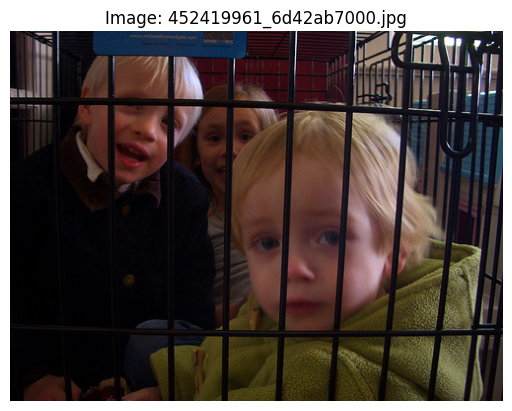

Generated (Greedy): man in black shirt pouring his face against window
Generated (Beam Search, k=5): an elderly man is reading book

Reference Captions:
  - the three children are in cage
  - three children are locked in cage
  - three children in black dog kennel
  - three small children are in cage
  - three well dressed blond children in cage
--------------------------------------------------


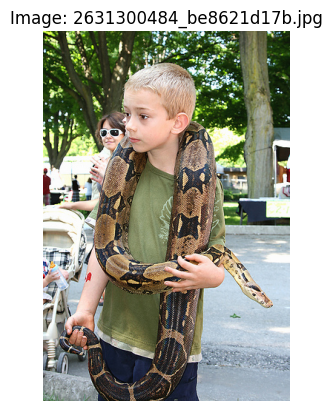

Generated (Greedy): woman in black shirt and leather jacket is holding camera
Generated (Beam Search, k=5): the woman in the black shirt is holding camera

Reference Captions:
  - blonde boy stands among people in shady setting with large snake wrapped around his chest
  - boy carries huge snake around his neck outside
  - boy has large snake wrapped around him
  - little boy in green shirt is holding large snake
  - young boy has snake draped over his shoulders
--------------------------------------------------


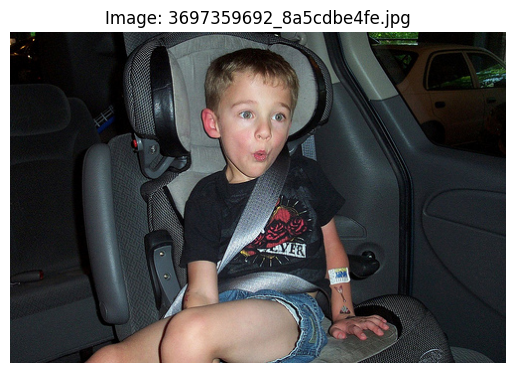

Generated (Greedy): person in black and black is sitting on bed
Generated (Beam Search, k=5): the person is sitting and playing uno

Reference Captions:
  - boy is sitting in car seat in the backseat of car
  - boy making face while sitting in his car seat
  - boy sitting in car making surprised face
  - young boy is buckled into car seat making silly face
  - the young boy with silly face is buckled in car seat


In [2]:
# -*- coding: utf-8 -*-
"""
Image Captioning with ResNet50 and BiLSTM on Flickr8k.
Refactored for clarity while preserving original model logic.
Includes full evaluation metrics and beam search decoding.
"""

# =============================================================================
# STEP 1: SETUP AND IMPORTS
# =============================================================================
import os
import string
import numpy as np
import pickle
from PIL import Image
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Embedding, Dropout, add
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# NLTK for tokenization
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)

# Evaluation libraries
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


# =============================================================================
# STEP 2: PATHS AND HYPERPARAMETERS
# =============================================================================
BASE_PATH = '/content/drive/MyDrive/model_captioning'
IMAGES_PATH = os.path.join(BASE_PATH, 'Flicker8k_Dataset')
CAPTIONS_FILE = os.path.join(BASE_PATH, 'Flickr8k_text/Flickr8k.token.txt')
TRAIN_FILE = os.path.join(BASE_PATH, 'Flickr8k_text/Flickr_8k.trainImages.txt')
DEV_FILE = os.path.join(BASE_PATH, 'Flickr8k_text/Flickr_8k.devImages.txt')
TEST_FILE = os.path.join(BASE_PATH, 'Flickr8k_text/Flickr_8k.testImages.txt')
FEATURES_PKL = os.path.join(BASE_PATH, 'features_resnet50.pkl')
MODEL_SAVE_PATH = os.path.join(BASE_PATH, 'model_resnet_bilstm_best.keras')

# Hyperparameters
EMBEDDING_DIM = 256
LSTM_UNITS = 256
DROPOUT_RATE = 0.5
BATCH_SIZE = 64
EPOCHS = 20
BEAM_WIDTH = 5


# =============================================================================
# STEP 3: DATA LOADING AND PREPROCESSING FUNCTIONS
# =============================================================================
def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

def load_set_ids(filename):
    doc = load_doc(filename)
    return set(line.split('.')[0] for line in doc.split('\n') if len(line) >= 1)

def load_captions(filename, dataset_ids):
    doc = load_doc(filename)
    captions = defaultdict(list)
    for line in tqdm(doc.split('\n'), desc="Loading raw captions"):
        tokens = line.split()
        if len(tokens) < 2: continue
        image_id, image_desc = tokens[0].split('.')[0], tokens[1:]
        if image_id in dataset_ids:
            captions[image_id].append(' '.join(image_desc))
    return captions

def clean_captions(captions_dict):
    table = str.maketrans('', '', string.punctuation)
    cleaned_captions = defaultdict(list)
    for key, desc_list in tqdm(captions_dict.items(), desc="Cleaning captions"):
        for desc in desc_list:
            desc_tokens = desc.split()
            desc_tokens = [word.lower() for word in desc_tokens]
            desc_tokens = [w.translate(table) for w in desc_tokens]
            desc_tokens = [word for word in desc_tokens if len(word) > 1 and word.isalpha()]
            cleaned_captions[key].append(' '.join(desc_tokens))
    return cleaned_captions

def add_start_end_tokens(captions_dict):
    processed_captions = defaultdict(list)
    for key, desc_list in captions_dict.items():
        processed_captions[key] = ['startseq ' + desc + ' endseq' for desc in desc_list]
    return processed_captions

# Execute data loading
print("--- Loading and Preprocessing Data ---")
train_ids = load_set_ids(TRAIN_FILE)
dev_ids = load_set_ids(DEV_FILE)
test_ids = load_set_ids(TEST_FILE)
print(f"IDs loaded: Train={len(train_ids)}, Dev={len(dev_ids)}, Test={len(test_ids)}")

all_ids = train_ids.union(dev_ids).union(test_ids)
all_captions_raw = load_captions(CAPTIONS_FILE, all_ids)
all_captions_cleaned = clean_captions(all_captions_raw)

# Data for training/validation (with start/end tokens)
train_captions = add_start_end_tokens({k: v for k, v in all_captions_cleaned.items() if k in train_ids})
dev_captions = add_start_end_tokens({k: v for k, v in all_captions_cleaned.items() if k in dev_ids})

# Data for evaluation (cleaned, no start/end tokens)
test_captions_cleaned = {k: v for k, v in all_captions_cleaned.items() if k in test_ids}

# =============================================================================
# STEP 4: IMAGE FEATURE EXTRACTION
# =============================================================================
def extract_features(directory, image_ids):
    model = ResNet50(weights='imagenet')
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    features = {}
    for name in tqdm(image_ids, desc="Extracting ResNet50 features"):
        filename = os.path.join(directory, name + '.jpg')
        try:
            image = load_img(filename, target_size=(224, 224))
            image = img_to_array(image)
            image = image.reshape((1, *image.shape))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            features[name] = feature # Shape (1, 2048)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    return features

if not os.path.exists(FEATURES_PKL):
    print("Extracting features for all images...")
    all_features = extract_features(IMAGES_PATH, all_ids)
    print(f"Extracted features for {len(all_features)} images.")
    with open(FEATURES_PKL, 'wb') as f:
        pickle.dump(all_features, f)
else:
    print(f"Loading pre-extracted features from {FEATURES_PKL}...")
    with open(FEATURES_PKL, 'rb') as f:
        all_features = pickle.load(f)

train_features = {k: all_features[k] for k in train_ids if k in all_features}
dev_features = {k: all_features[k] for k in dev_ids if k in all_features}
test_features = {k: all_features[k] for k in test_ids if k in all_features}
print(f"Features loaded: Train={len(train_features)}, Dev={len(dev_features)}, Test={len(test_features)}")

feature_size = list(train_features.values())[0].shape[-1] if train_features else 2048


# =============================================================================
# STEP 5: TOKENIZATION AND DATA GENERATOR
# =============================================================================
def create_tokenizer(captions_dict):
    all_desc_list = [cap for desc_list in captions_dict.values() for cap in desc_list]
    tokenizer = Tokenizer(oov_token="<unk>")
    tokenizer.fit_on_texts(all_desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(d.split()) for d_list in train_captions.values() for d in d_list)
print(f"Vocabulary Size: {vocab_size}, Max Caption Length: {max_length}")
word_to_index = tokenizer.word_index
index_to_word = {idx: word for word, idx in word_to_index.items()}

# --- DATA GENERATOR (LOGIC GIỮ NGUYÊN NHƯ CODE GỐC CỦA BẠN) ---
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size, feature_size):
    X1, X2, y = list(), list(), list()
    n = 0
    desc_items = []
    for key, desc_list in descriptions.items():
        if key in photos:
            for desc in desc_list:
                desc_items.append((key, desc))

    while True:
        np.random.shuffle(desc_items)
        for key, desc in desc_items:
            n += 1
            photo = photos[key][0] # Lấy ra array (feature_size,)
            seq = tokenizer.texts_to_sequences([desc])[0]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)

            if n >= batch_size:
                # Trả về batch đúng định dạng model mong đợi
                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

# =============================================================================
# STEP 6: MODEL DEFINITION
# =============================================================================
def define_model_bilstm(vocab_size, max_length, feature_size, embedding_dim, lstm_units):
    inputs1 = Input(shape=(feature_size,)) # Input shape (2048,)
    fe1 = Dropout(DROPOUT_RATE)(inputs1)
    fe2_adapted = Dense(2 * lstm_units, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,)) # Input shape (34,)
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(DROPOUT_RATE)(se1)
    se3 = Bidirectional(LSTM(lstm_units))(se2)

    decoder1 = add([fe2_adapted, se3])
    decoder2 = Dense(lstm_units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# =============================================================================
# STEP 7: TRAINING
# =============================================================================
print("\n--- Starting Model Training ---")
if os.path.exists(MODEL_SAVE_PATH):
    print(f"--- Found existing model at {MODEL_SAVE_PATH}. Loading model... ---")
    # Nếu file đã tồn tại, chỉ cần load nó lên
    best_model = load_model(MODEL_SAVE_PATH)
    print("Model loaded successfully.")

else:
    # Nếu file chưa tồn tại, chúng ta mới bắt đầu quá trình huấn luyện
    print(f"--- Model not found. Starting a new training session... ---")

    # Định nghĩa model
    model = define_model_bilstm(vocab_size, max_length, feature_size, EMBEDDING_DIM, LSTM_UNITS)

    # Tính steps_per_epoch
    num_sequences_train = sum(len(d.split()) - 1 for d_list in train_captions.values() for d in d_list)
    steps_train = num_sequences_train // BATCH_SIZE
    if num_sequences_train % BATCH_SIZE != 0: steps_train += 1

    num_sequences_dev = sum(len(d.split()) - 1 for d_list in dev_captions.values() for d in d_list)
    steps_dev = num_sequences_dev // BATCH_SIZE
    if num_sequences_dev % BATCH_SIZE != 0: steps_dev += 1

    print(f"Total training sequences: {num_sequences_train}, Steps per epoch: {steps_train}")
    print(f"Total validation sequences: {num_sequences_dev}, Validation steps: {steps_dev}")

    # Tạo generator
    train_gen = data_generator(train_captions, train_features, tokenizer, max_length, vocab_size, BATCH_SIZE, feature_size)
    dev_gen = data_generator(dev_captions, dev_features, tokenizer, max_length, vocab_size, BATCH_SIZE, feature_size)

    # Callbacks
    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Bắt đầu huấn luyện
    history = model.fit(
        train_gen,
        epochs=EPOCHS,
        steps_per_epoch=steps_train,
        validation_data=dev_gen,
        validation_steps=steps_dev,
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    print(f"Training completed. Best model saved to {MODEL_SAVE_PATH}")
    # Sau khi huấn luyện, model tốt nhất đã được load vào biến `model` nhờ `restore_best_weights=True`
    best_model = model


# =============================================================================
# STEP 8: EVALUATION FUNCTIONS
# =============================================================================
def generate_caption_greedy(model, tokenizer, photo_feature, max_length):
    # photo_feature có shape (1, feature_size)
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo_feature, sequence], verbose=0)
        yhat_idx = np.argmax(yhat)
        word = index_to_word.get(yhat_idx)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return ' '.join(in_text.split()[1:])

def generate_caption_beam_search(model, tokenizer, photo_feature, max_length, beam_width):
    start_token_idx = word_to_index['startseq']
    sequences = [([start_token_idx], 0.0)]

    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == word_to_index.get('endseq', -1):
                all_candidates.append((seq, score))
                continue
            input_seq = pad_sequences([seq], maxlen=max_length)
            predictions = model.predict([photo_feature, input_seq], verbose=0)[0]
            top_k_indices = np.argsort(predictions)[-beam_width:]
            for word_idx in top_k_indices:
                new_seq = seq + [word_idx]
                new_score = score + np.log(predictions[word_idx] + 1e-9)
                all_candidates.append((new_seq, new_score))
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_width]
        if all(s[0][-1] == word_to_index.get('endseq', -1) for s in sequences):
            break

    best_seq = sequences[0][0]
    caption_words = [index_to_word.get(idx) for idx in best_seq]
    return ' '.join(word for word in caption_words if word not in ['startseq', 'endseq', None])

# --- HÀM ĐÁNH GIÁ ĐÃ SỬA LỖI ---
def evaluate_model_full(model, tokenizer, features_dict, captions_cleaned_dict, max_length, generation_method='greedy', beam_width=3):
    print(f"\n--- Starting Full Evaluation on {len(features_dict)} Images ---")
    print(f"--- Generation Method: {generation_method.upper()} ---")

    gts = {} # Ground truth: dict[image_id] -> [ref1, ref2, ...]
    res = {} # Result: dict[image_id] -> [generated_caption]

    for image_id, photo_feature in tqdm(features_dict.items(), desc="Generating captions"):
        if generation_method == 'beam':
            generated_caption = generate_caption_beam_search(model, tokenizer, photo_feature, max_length, beam_width)
        else:
            generated_caption = generate_caption_greedy(model, tokenizer, photo_feature, max_length)

        # Sửa lỗi: Truyền đúng định dạng cho thư viện
        res[image_id] = [generated_caption]
        gts[image_id] = captions_cleaned_dict[image_id]

    # Khởi tạo các đối tượng tính score
    scorers = { "Bleu": Bleu(4), "METEOR": Meteor(), "ROUGE_L": Rouge(), "CIDEr": Cider(), "SPICE": Spice() }

    final_scores = {}
    for name, scorer in scorers.items():
        print(f'Computing {name} score...')
        score, scores = scorer.compute_score(gts, res)
        if isinstance(score, list): # Xử lý riêng cho BLEU trả về list 4 score
            for i, s in enumerate(score):
                final_scores[f"Bleu_{i+1}"] = s
        else:
            final_scores[name] = score

    print("\n--- Full Evaluation Results ---")
    for method, score in final_scores.items():
        print(f'{method}: {score:.4f}')

    return final_scores

def show_qualitative_examples(model, tokenizer, features_dict, captions_cleaned_dict, max_length, num_examples=3):
    print("\n--- Qualitative Examples ---")
    image_ids = list(features_dict.keys())
    sample_ids = np.random.choice(image_ids, size=num_examples, replace=False)

    for image_id in sample_ids:
        print("-" * 50)
        img_path = os.path.join(IMAGES_PATH, image_id + '.jpg')
        pil_image = Image.open(img_path)
        plt.imshow(pil_image)
        plt.title(f"Image: {image_id}.jpg")
        plt.axis('off')
        plt.show()

        photo_feature = features_dict[image_id]
        greedy_caption = generate_caption_greedy(model, tokenizer, photo_feature, max_length)
        beam_caption = generate_caption_beam_search(model, tokenizer, photo_feature, max_length, beam_width=BEAM_WIDTH)

        print(f"Generated (Greedy): {greedy_caption}")
        print(f"Generated (Beam Search, k={BEAM_WIDTH}): {beam_caption}")

        print("\nReference Captions:")
        for ref_cap in captions_cleaned_dict[image_id]:
            print(f"  - {ref_cap}")

# =============================================================================
# STEP 9: FINAL EVALUATION AND VISUALIZATION
# =============================================================================
print("\n--- Final Model Evaluation ---")
# Biến `best_model` bây giờ đã chứa model (hoặc được load, hoặc vừa huấn luyện xong)
if 'best_model' in locals():
    # Đánh giá trên toàn bộ tập test
    print("\n--- Evaluating with Greedy Search ---")
    evaluate_model_full(best_model, tokenizer, test_features, test_captions_cleaned, max_length, generation_method='greedy')

    print("\n--- Evaluating with Beam Search ---")
    evaluate_model_full(best_model, tokenizer, test_features, test_captions_cleaned, max_length, generation_method='beam', beam_width=BEAM_WIDTH)

    # Hiển thị ví dụ
    show_qualitative_examples(best_model, tokenizer, test_features, test_captions_cleaned, max_length, num_examples=3)
else:
    print("Error: Model is not defined. Please train a model or ensure it is loaded correctly.")

In [1]:
show_qualitative_examples(best_model, tokenizer, test_features, test_captions_cleaned, max_length, num_examples=3)

NameError: name 'show_qualitative_examples' is not defined